In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

C:\Users\MLoong\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting?resource=download

In [2]:
data = pd.read_csv('Turbine_Data.csv')

In [3]:
pd.isna(data).sum()

Unnamed: 0                          0
ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
ControlBoxTemperature           56064
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WTG                                 0
WindDirection                   45946
WindSpeed                       23629
dtype: int64

In [4]:
data = data.dropna(subset=['ActivePower', 'WindSpeed'])

# Origional Wind and Power

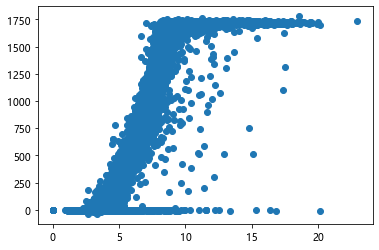

In [5]:
plt.scatter(data.WindSpeed, data.ActivePower)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[['WindSpeed']], data['ActivePower'], test_size=0.33, shuffle=False)

# Without clean

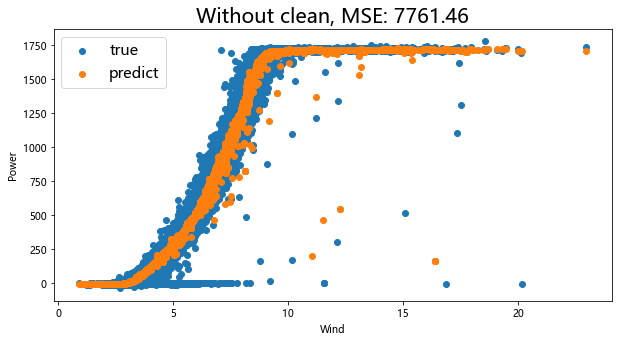

In [7]:
xgb = XGBRegressor()
xgb.fit(X_train[['WindSpeed']], y_train)
plt.figure(figsize=(10, 5))
plt.scatter(X_test.WindSpeed, y_test)
plt.scatter(X_test.WindSpeed, xgb.predict(X_test[['WindSpeed']]))
plt.legend(['true', 'predict'], fontsize = 15)
plt.title('Without clean, MSE: ' + str(round(mean_squared_error(y_test, xgb.predict(X_test[['WindSpeed']])), 2)), fontsize=20)
plt.xlabel('Wind')
plt.ylabel('Power')
plt.show()

# Clean train set

## The wind and power relation is close to sigmod function

In [8]:
def sigmod(x):
    return 1/(1 + np.exp(-(x - 0.5) * 20))

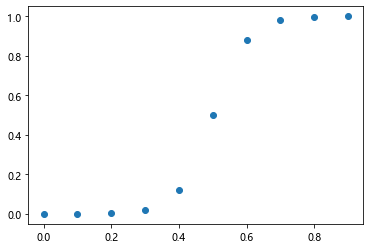

In [9]:
plt.scatter(np.arange(0, 1, 0.1), sigmod(np.arange(0, 1, 0.1)))

In [10]:
max_wind = max(X_train.WindSpeed)
max_power = max(y_train)

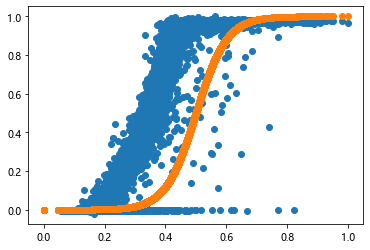

In [11]:
plt.scatter(X_train.WindSpeed/max_wind, y_train/max_power)
plt.scatter(X_train.WindSpeed/max_wind, sigmod(X_train.WindSpeed/max_wind))

In [12]:
def sigmod(x):
    return 1/(1 + np.exp(-(x - 0.35) * 20))

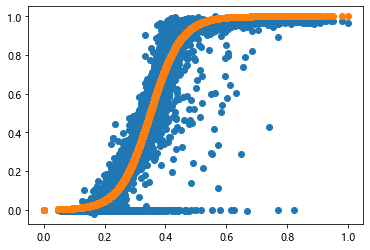

In [13]:
plt.scatter(X_train.WindSpeed/max_wind, y_train/max_power)
plt.scatter(X_train.WindSpeed/max_wind, sigmod(X_train.WindSpeed/max_wind))

# Scale data to (0, 1)

In [14]:
X_train.WindSpeed = X_train.WindSpeed/max_wind
y_train = y_train/max_power

In [15]:
X_train['modify'] = sigmod(X_train.WindSpeed)

In [16]:
X_train['diff'] = abs(y_train - X_train['modify'])

In [17]:
X_train['diff'].describe()

count    6.327200e+04
mean     3.765178e-02
std      4.490854e-02
min      2.073206e-07
25%      1.338762e-02
50%      2.511245e-02
75%      5.116872e-02
max      1.002718e+00
Name: diff, dtype: float64

Text(0.5, 1.0, 'Clean')

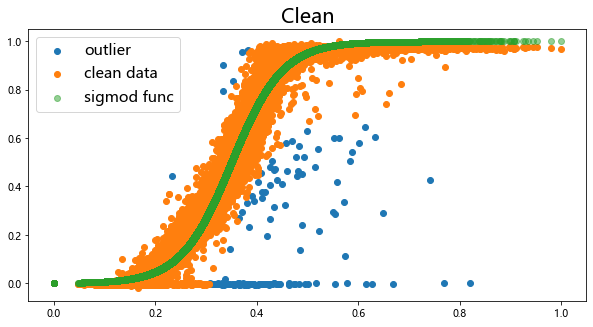

In [18]:
t = 0.3
plt.figure(figsize=(10, 5))
plt.scatter(X_train[X_train['diff'] > t].WindSpeed, y_train[X_train['diff'] > t])
plt.scatter(X_train[X_train['diff'] <= t].WindSpeed, y_train[X_train['diff'] <= t])
plt.scatter(X_train.WindSpeed, sigmod(X_train.WindSpeed), alpha=0.5)
plt.legend(['outlier', 'clean data', 'sigmod func'], fontsize = 15)
plt.title('Clean', fontsize = 20)

In [19]:
y_train = y_train[X_train['diff'] <= t]
X_train = X_train[X_train['diff'] <= t]

# Rescale data

In [20]:
X_train.WindSpeed = X_train.WindSpeed * max_wind
y_train = y_train * max_power

# After clean

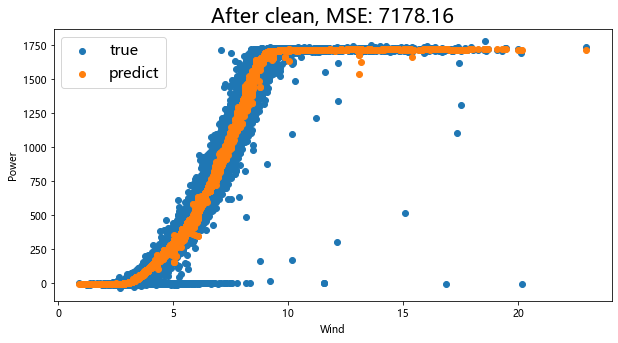

In [21]:
xgb = XGBRegressor()
xgb.fit(X_train[['WindSpeed']], y_train)
plt.figure(figsize=(10, 5))
plt.scatter(X_test.WindSpeed, y_test)
plt.scatter(X_test.WindSpeed, xgb.predict(X_test[['WindSpeed']]))
plt.legend(['true', 'predict'], fontsize = 15)
plt.title('After clean, MSE: ' + str(round(mean_squared_error(y_test, xgb.predict(X_test[['WindSpeed']])), 2)), fontsize=20)
plt.xlabel('Wind')
plt.ylabel('Power')
plt.show()

# Feature engineering

In [22]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'{ts.name}_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [23]:
lags = 4
lag_df = make_lags(X_train.WindSpeed, lags = lags)
X_train = pd.concat([X_train, lag_df], axis=1)
lag_df = make_lags(X_test.WindSpeed, lags = lags)
X_test = pd.concat([X_test, lag_df], axis=1)

In [24]:
features = ['WindSpeed'] + lag_df.columns.to_list()

# After feature engineering

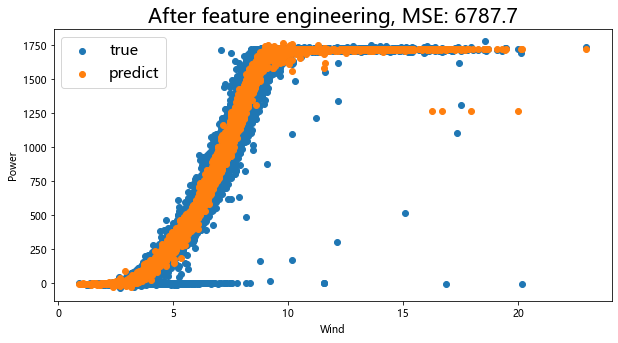

In [25]:
xgb = XGBRegressor()
xgb.fit(X_train[features], y_train)
plt.figure(figsize=(10, 5))
plt.scatter(X_test.WindSpeed, y_test)
plt.scatter(X_test.WindSpeed, xgb.predict(X_test[features]))
plt.legend(['true', 'predict'], fontsize = 15)
plt.title('After feature engineering, MSE: ' + str(round(mean_squared_error(y_test, xgb.predict(X_test[features])), 2)), fontsize=20)
plt.xlabel('Wind')
plt.ylabel('Power')
plt.show()